The basic problem of geolocalization to extract locations from (preferably many) measurements.  I'll start by doing this on a plane, and we can progress to a network later if that works.  Locations are thus expressed in two coordinates -- $\theta$ and $\varphi$, or lat and lon, or $x$ and $y$.

### Some math.

The approach that follows derives from my work on the ATLAS Fast TracKer, which was just a PCA firmware supercomputer.  Looking over this, the PCA is not really needed here -- it was just a convenience since the main interest was very, very rapid calculation of the linearized $\chi^2$.  But the calculation of the location fit parameters is quite useful.  I have basically extracted this derivation from Chapter 4 of the technical design report of the Silicon Vertex Tracker (cdf/doc/trigger/public/3108), which was its predecessor at CDF (Collider Detector at Fermilab).  Unfortunately, this document does not appear to be publicly available.

For a perfect system without noise, we have a location $\vec{x}$ that can be expressed as a function of parameters $\vec{p}$:
* $\vec{x} = \vec{x}(\vec{p})$

For localization, we would invert and linearize the parameter and measurement functions:
* $p_i = p_i(\vec{x}) \approx \vec{w}_i \cdot \vec{x} + q_i$

The problem of localization is now to find $\vec{w}_i$ and $q_i$.  To do that, just fit!  We will do this using a (simulated) covariance matrix.  We minimize the error / variance of the true values $\tilde{p}_i$ with respect to the predictions $p_i(\vec{x})$.  What we're really looking at is:
* $p_i(\vec{x}) = \vec{w}_i \cdot \vec{x} + q_i$
* $\tilde{p}_i - p_i(\vec{x}) = \tilde{p}_i - \vec{w}_i \cdot \vec{x} - q_i$
* $\tilde{p}_i - p_i(\vec{x}) = -(\vec{w}_i \cdot \vec{x} - \tilde{p}_i + q_i)$

(The last line, flipping the sign, is just slightly nicer, moving forward.  We'll square everything anyway, so signs are a bit irrelevant.)

Defining $\vec{X} \equiv (\vec{x}, \tilde{p}_i)$ and $\vec{W}_i \equiv (\vec{w}_i, -1)$, we can write the error as
* $\tilde{p}_i - p_i(\vec{x}) = \vec{W}_i \cdot \vec{X} + q_i$

We want to minimize
* $\partial (\tilde{p}_i - p_i(\vec{x}))^2 / \partial w_i = 0$

Restated, we want to minimize the variance of $\vec{W}_i \cdot \vec{X}$ with respect to $\vec{W}_i$.  Recall that the covariance of the product $\vec{b}\vec{X}$ is $\vec{b} \text{cov}(X)\vec{b}^T$.  Since we're minimizing with respect to $\vec{w}_i$, the $q_i$'s drop off and it's just minimizing 
* $\text{cov}(\tilde{p}_i - p_i(\vec{x})) = \vec{W}_i \text{cov}(\vec{X}) \vec{W}_i$

This finally reaches the punchline.  We can easily use simulation to estimate the covariance of $\vec{X}$.
Let's be explict then, that this covariance is
* $C = \begin{pmatrix} M & \gamma \\ \gamma^T & \sigma^2(\tilde{p}_i)\end{pmatrix}$

where $M$ is the covariance of the _measurements_ and $\gamma$ is the covariance of the measurments with the true parameters, $\gamma = \langle{\tilde{p}_i \vec{x}}\rangle - \langle{\tilde{p}_i\rangle \langle\vec{x}}\rangle$.  So we can write this
* $\text{cov}(\tilde{p}_i - p_i(\vec{x})) = \vec{w}_i M \vec{w}_i - 2 \vec{w}_i \cdot \gamma + \sigma^2(\tilde{p}_i)$

Minimizing with respect to $\vec{w}_i$, we get
* $M \vec{w}_i = \vec{\gamma}$
* $\vec{w}_i = M^{-1}\vec{\gamma}$.

With known $\vec{w}_i$, it is trivial to find the offsets, 
* $q_i = \langle \tilde{p}_i \rangle - \langle \vec{w}_i \cdot \vec{x} \rangle$.

The problem thus reduces to simulating the combined covariance matrix of the measurements and true parameters.  In the "real world," this requires a sample where the locations $\vec{x}$ are measured with minimal error -- either from GPS or from highly-localized CIDR blocks.

Note that this should automatically account for varying latencies or server responses, but that it assumes that things are linear in the parameters.  This means that segmenting / block diagonalizing the data judiciously (e.g., by carrrier) will probably help.

It is useful to note the measurement functions $\vec{x}(\vec{p})$ can also be written as a constraint equations:
* $f_i(\vec{x}) = 0$.

Note that the quantities are only identically 0 if measurements are perfect and there is no noise etc.  In practice, there will be some variance, which we'd like to quantify.  If we have $N$ measurements and two degrees of freedom, there are $N-2$ such equations.

Linearizing these constraints are linearized, we have:
* $f_i(\vec{x}) \approx \vec{v}_i \cdot \vec{x} + c_i$

Using the same multiplication rue for covariance as above, we can write out the variance of this as:
* $\sigma_f^2 \approx \vec{v}  M  \vec{v}$

Alternatively, we can just note that if $\vec{x}$ is a random vector with covariance matrix $M$, that $(\vec{x}  - \langle\vec{x}\rangle)^T  M^{-1} (\vec{x}  - \langle\vec{x}\rangle)$ follows a $\chi^2$ distribution.

At any rate, if we can estimate the covariance matrix -- and this can be done from either data or simulation -- then we can get a measure of the goodness of fit of a new location, and if that location is an outlier.

We don't actually need PCA -- diagonalization of the covariance matrix -- at this point, but it offers a bit of insight.  Decompose $M$ into eigenvectors $\vec{u}_i$ and eigenvalues $\lambda_i$, so $M^{-1} = Q^{-1} \Lambda^{-1} Q$.  If we write this as $\Lambda_{ii} = \lambda_i$, that's 
* $M^{-1}_{ik} = Q^{-1}_{ik} \frac{\delta_{kj}}{\lambda_k}  Q_{kj}$.

We can take either half of that matrix as $A_{ij} = u_{ij}/\sqrt{\lambda_i}$.

Note that $1/\sqrt{\lambda_i}$ is basically the standard deviation for that constraint.  We can thus write the constraints as a single sum:
* $\chi^2 = \sum_i \sum_j A_{ij} x_j + c_i$

(Since the constraints are set to 0, the offsets of the constraints $c_i$ can be derived as $c_i = \langle \vec{v}_{i} \cdot \vec{x} \rangle$.)

There are two real degrees of freedom here, and so $M$ will have two large eigenvalues -- call them $\lambda_0$ and $\lambda_1$.  For those two cases, $1/\lambda_0$ and $1/\lambda_1$ will be _small_, and their contributions to the $\chi^2$ minimal.  The main contribution comes from the other $N-2$ measurements.

### Computational example.

Lets simulate $L$ landmarks and $N$ locations.  Their physical locations of location $i$ to landmark $\ell$ are $\vec{x}_i$ and $\vec{x}_i$, and the distances between them are $d_{i\ell}$.

From these measures, we have construct a vectors $v$ of length $L+2$ for each location, for which we want to construct the covariance matrix $C$.  We then find our linearized position from

* $p_i(\vec{x}) \approx \vec{w}_i \cdot \vec{x} + q_i$
* $\vec{w}_i = M^{-1}\vec{\gamma}$.
* $q_i = \langle \tilde{p}_i \rangle - \langle \vec{w}_i \cdot \vec{x} \rangle$.

Imports:

In [1]:
import numpy as np
from scipy.spatial import distance

Simulation constants:

In [2]:
dim, L, N = 2, 50, 100000

Define the landmarks and locations.  Note: I would have expected that the location space would have to be pretty small for the linear approximations of the covariance to work.  But it works even when the locations span the entire landmark space.  It is quite interesting to play with the geometry of the landmarks to see how this coverage affects the space.  The landmarks commented out here are quite effective, with just 8 locations.

In [3]:
landmarks = np.random.rand(L, dim)

# landmarks = np.array([[0, 0], [0, 1], [1, 0], [1, 1], 
#                       [0, 0.5], [0.5, 0], [1, 0.5], [0.5, 1]])

# L = landmarks.shape[0]

# x, y, dx, dy = 0.2, 0.3, 0.05, 0.05
x, y, dx, dy = 0, 0, 1, 1
locations = np.random.rand(N, dim) * np.array([dx, dy]) + np.array([x, y])

And the distances between them:

In [4]:
distances = distance.cdist(landmarks, locations)

Now append the true parameters / locations to the measurements / distances.

In [5]:
vectors = np.concatenate([distances, locations.T])

Calculate the covariance matrix $C$, the distance covariances $M$, and the cross term $\gamma$:

In [6]:
C = np.cov(vectors)

Minv = np.linalg.inv(C[:L,:L])

gamma = C[:L,-2:]

And then take the matrix product to get the parameters.

In [7]:
wi = np.matmul(Minv, gamma)

The offsets are the differences of the means of the locations and the products $\vec{w} \cdot \vec{x}$.

In [8]:
mean_loc = np.mean(locations, axis = 0)
mean_lin = np.mean(np.matmul(wi.T, distances), axis = 1)

qi = mean_loc - mean_lin

We can now reconstruct the locations like so:

In [9]:
rec = np.matmul(wi.T, distances) + qi[:,np.newaxis]

Let's look at the errors.  First generate and evaluate a new test sample...

In [10]:
test_loc = np.random.rand(N, dim)
test_distances = distance.cdist(landmarks, test_loc)

reco_loc = np.matmul(wi.T, test_distances) + qi[:,np.newaxis]

In [11]:
locT = test_loc.T

errx = locT[0] - reco_loc[0]
erry = locT[1] - reco_loc[1]

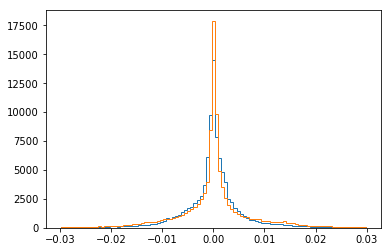

In [12]:
fig, ax = plt.subplots()

extent = max(np.quantile(np.abs(errx), 0.99), 
             np.quantile(np.abs(erry), 0.99))

bins = np.linspace(-extent, extent, 100)

ax.hist(errx, histtype = "step", bins = bins)
ax.hist(erry, histtype = "step", bins = bins)

ax

And the coverage...

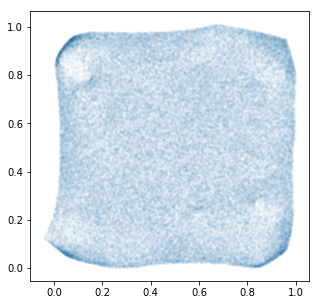

In [13]:
fig, ax = plt.subplots(subplot_kw = {"aspect" : "equal"}, figsize = (5, 5))

ax.scatter(reco_loc[0], reco_loc[1], alpha = 0.02, lw = 0, s = 10)